# Mean strain and high-strain manifold analyses

In this code, we analyse the data processed from multiple Uniprot IDs. The calculations were perfomed using the python scripts in a server.

The data, in summary, consists of:

- Extensive strain (stretch) for all residues and all possible pairwise comparisons within groups (P x P, P x N, and N x N)
- Correlation dimension
- Pairwise atomic distance
- Residue index aligned across structures

Here, we average the data across all possible pairwise comparisons of the same group to estimate strain at (and correlation dimension of):

- The vicinity of the phosposite (i $\pm$ 2 res)
- The residues that compose the functional site
- All the remaining residues, here denoted as background

P: Phosphorylated structure;
N: Non-phosphorylated structure

## Importing libraries

In [1]:
import matplotlib.pyplot as plt
from matplotlib import colormaps as cmaps
from matplotlib import cm

import pandas as pd
import numpy as np
from scipy.optimize import curve_fit as fit
from scipy.spatial.distance import squareform
import warnings
import os
warnings.filterwarnings('ignore')


import psa.load as load
import psa.sequence as seq
import psa.elastic as elastic

from scipy.stats import kruskal, mannwhitneyu, wilcoxon
from scipy.stats import hypergeom
from scipy.stats.stats import pearsonr


## Loading filtered protein dataset

In [2]:
data = pd.read_csv("data/metadata/filtered_df.csv")
data

,UNIPROT,UNIPROT_RESIDUE_NUMBER,ENTRY_ID_ONE,AUTH_ASYM_ID_ONE,STRUCT_ASYM_ID_ONE,AUTH_SEQ_ID_ONE,PDB_SEQ_ID_ONE,CHEM_COMP_ONE,ENTRY_ID_TWO,AUTH_ASYM_ID_TWO,...,AUTH_SEQ_ID_TWO,PDB_SEQ_ID_TWO,CHEM_COMP_TWO,AUTH_FULL_ONE,AUTH_FULL_TWO,RENAMED_ASYM_ID_ONE,RENAMED_ASYM_ID_TWO,RENAMED_ENTITY_ONE,RENAMED_ENTITY_TWO,PHOSPHOSITE
0,P24941,160,2r3p,A,A,160.0,161,THR,5nev,C,...,160.0,165,TPO,2r3p_A,5nev_C,A,C,2r3p_A,5nev_C,P24941_160
1,P24941,160,2r3p,A,A,160.0,161,THR,2g9x,A,...,160.0,161,TPO,2r3p_A,2g9x_A,A,A,2r3p_A,2g9x_A,P24941_160
2,P24941,160,2r3p,A,A,160.0,161,THR,2wma,A,...,160.0,165,TPO,2r3p_A,2wma_A,A,A,2r3p_A,2wma_A,P24941_160
3,P24941,160,2r3p,A,A,160.0,161,THR,2uzb,A,...,160.0,160,TPO,2r3p_A,2uzb_A,A,A,2r3p_A,2uzb_A,P24941_160
4,P28482,187,4qp4,A,A,187.0,196,TYR,6opg,A,...,185.0,181,PTR,4qp4_A,6opg_A,A,A,4qp4_A,6opg_A,P28482_187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135117,P63086,183,6fle,A,A,183.0,189,THR,3zuv,C,...,183.0,189,TPO,6fle_A,3zuv_C,A,C,6fle_A,3zuv_C,P63086_183
135118,P25321,140,5m6y,A,A,139.0,142,SER,5n1g,A,...,139.0,142,SEP,5m6y_A,5n1g_A,A,A,5m6y_A,5n1g_A,P25321_140
135119,P25321,140,5m6y,A,A,139.0,142,SER,6eh2,A,...,139.0,142,SEP,5m6y_A,6eh2_A,A,A,5m6y_A,6eh2_A,P25321_140
135120,P24941,160,3qx2,A,A,160.0,168,THR,3bhv,C,...,160.0,162,TPO,3qx2_A,3bhv_C,A,C,3qx2_A,3bhv_C,P24941_160


## Creates dictionaries for Phosphorylated and Non-phosphorylated proteins for the each Uniprot entry

In [3]:
protP_accession = {}
protN_accession = {}
phosp_type = {}

psites = list(set(data["PHOSPHOSITE"]))
psites.sort()

for psite in psites:
    dataA = data[data["PHOSPHOSITE"] == psite]
    
    protein = psite.split("_")[0]
    
    protP_accession[psite] = list(set(dataA["AUTH_FULL_TWO"]))
    protN_accession[psite] = list(set(dataA["AUTH_FULL_ONE"]))
    phosp_type[psite] = list(set(dataA["CHEM_COMP_ONE"]))[0]

## Scatter plot style

In [4]:
def fancy_scatter(ax, xdata, ydata, color, size, lw, alpha):
    """
    Create a layered scatter plot on the given Axes object `ax`.

    Parameters:
    - ax: Matplotlib Axes object to draw on
    - xdata, ydata: Coordinates of the scatter points
    - color: Final visible color of the points
    - size: Size of the scatter points
    - lw: Line width for the black outline
    - alpha: Transparency of the final color layer
    """    
    ax.scatter(xdata, ydata, color = "black", s = size, lw = lw)
    ax.scatter(xdata, ydata, color = "white", s = size, lw = 0)
    ax.scatter(xdata, ydata, color = color, s = size, lw = 0, alpha = alpha)
    return

## Loading functional dataset and assign specific indexes to functional sites

In [5]:
annot = pd.read_csv("data/metadata/uniprot_site_annotation.csv")

# Reformat missing data
annot = annot.replace(np.nan, "")

# Create a variable to describe each group of residues for a functional site
annot["group"] = annot["uniprot_id"] + ":" + annot["site_type"] + ":" + annot["description"] + ":" + annot["ligand"]

# Assign indexes for functional sites and Uniprot IDs
annot["site_idx"] = 0
annot["uniprot_idx"] = 0
for i in range(1, len(annot)):
    # For functional site
    if annot.iloc[i, 5] == annot.iloc[i-1, 5]:
        annot.iloc[i, 6] = annot.iloc[i-1, 6]
    else:
        annot.iloc[i, 6] = annot.iloc[i-1, 6] + 1
    
    # For Uniprot ID
    if annot.iloc[i, 0] == annot.iloc[i-1, 0]:
        annot.iloc[i, 7] = annot.iloc[i-1, 7]
    else:
        annot.iloc[i, 7] = annot.iloc[i-1, 7] + 1

# Number of different functional sites
annot_n = len(set(annot["site_idx"]))

# Uniprot IDs annotated
annot_uni = list(set(annot["uniprot_id"]))
annot_uni.sort()

annot

,uniprot_id,site_type,residue,description,ligand,group,site_idx,uniprot_idx
0,A0A0K8P8E7,Active site,225,Acyl-ester intermediate,,A0A0K8P8E7:Active site:Acyl-ester intermediate:,0,0
1,A0A0K8P8E7,Active site,492,Charge relay system,,A0A0K8P8E7:Active site:Charge relay system:,1,0
2,A0A0K8P8E7,Active site,528,Charge relay system,,A0A0K8P8E7:Active site:Charge relay system:,1,0
3,A0A0K8P8E7,Binding site,132,,4-[(2-hydroxyethoxy)carbonyl]benzoate,A0A0K8P8E7:Binding site::4-[(2-hydroxyethoxy)c...,2,0
4,A0A0K8P8E7,Binding site,226,,4-[(2-hydroxyethoxy)carbonyl]benzoate,A0A0K8P8E7:Binding site::4-[(2-hydroxyethoxy)c...,2,0
...,...,...,...,...,...,...,...,...
3120,Q9Y6E0,Binding site,114,,ATP,Q9Y6E0:Binding site::ATP,653,189
3121,Q9Y6E0,Binding site,161,,Mg(2+),Q9Y6E0:Binding site::Mg(2+),654,189
3122,Q9Y6E0,Binding site,174,,Mg(2+),Q9Y6E0:Binding site::Mg(2+),654,189
3123,Q9Y6E0,Site,325,Cleavage,,Q9Y6E0:Site:Cleavage:,655,189


## Identifying invalid entries in the strain and correlation dimension datasets

In [38]:
comparison_label = ["PP", "PN", "NN"]
is_nan = np.zeros((len(psites), 3), dtype = bool)

for i, psite in enumerate(psites):
    res = int(psite.split("_")[1])
    
    for j, label in enumerate(comparison_label):
        try:
            all_comparisons = np.load("data/server/output_cd/" + psite + "_" + label + ".npy", allow_pickle = True)
            for comp in all_comparisons:
                x = len([array for array in comp if np.sum(np.isnan(array)) == 0])
                if x == 0:
                    is_nan[i, j] = True
        except:
            is_nan[i, j] = True


## Defining functions to calculate mean strain

In [7]:
def geom_mean(x):
    """
    Computes the geometric mean of an array `x`.
    
    Parameters:
    - x: array-like of positive numbers
    
    Returns:
    - Geometric mean of the input array
    """
    return np.exp(np.mean(np.log(x)))
    

def mean_l3(all_comparisons, res, groups, random=False, seed=0):
    """
    Computes geometric mean values (lambda 3) for different residue sets:
    - phosphosite window (res±2)
    - background residues (all others)
    - specified feature site groups

    Parameters:
    - all_comparisons (list): A list of tuples, each representing one comparison.
                              Each tuple contains:
                                - comp[0]: correlation dimension per residue
                                - comp[1]: strain per residue
                                - comp[2]: list of residue indices 
    - res: integer, residue index around which a 5-residue window is centered
    - groups: list of identifiers corresponding to feature site groups
    - random: whether to shuffle values before computing means (for control)
    - seed: random seed for reproducibility if shuffling

    Returns:
    - Tuple of (mean phosphosite window L3, mean background L3, list of mean L3 per group)
    """
    
    # Initialize lists for each feature group
    fsite_temp = [[] for _ in groups]
    bground_temp = []  # Background residues
    psite_temp = []    # Phosphosite window

    for c, comp in enumerate(all_comparisons):            
        if type(comp) == tuple:
            # Identify residues in the window [res-2, ..., res+2]
            interval = np.sum([x == comp[2] for x in [res-2, res-1, res, res+1, res+2]], axis=0, dtype=bool)
            other = ~interval  # Background residues

            # Randomize L3 values if requested
            if random:
                np.random.seed(seed)
                size = len(comp[1])
                l3 = comp[1][np.random.choice(size, size, replace=False)]
            else:
                l3 = comp[1]

            # Compute geometric means for each group
            for g, group in enumerate(groups):
                data_group = data_prot[data_prot["site_idx"] == group]
                res_group = list(data_group["residue"])
                
                res_group = np.sum([x == comp[2] for x in res_group], axis=0, dtype=bool)
                other = ~(~other + res_group)  # Exclude current group from background
                
                if np.sum(res_group) != 0:
                    fsite_temp[g].append(geom_mean(l3[res_group]))
    
            # Append phosphosite window and background means
            psite_temp.append(geom_mean(l3[interval]))
            bground_temp.append(geom_mean(l3[other]))

    # Return average L3 values
    return (
        np.nanmean(psite_temp),
        np.nanmean(bground_temp),
        [np.nanmean(g) for g in fsite_temp]
    )

def prot_l3(all_comparisons, random=False, seed=0):
    """
    Computes the average geometric mean (L3) across all residue comparisons,
    used as a global protein-level metric.

    Parameters:
    - all_comparisons (list): A list of tuples, each representing one comparison.
                              Each tuple contains:
                                - comp[0]: correlation dimension per residue
                                - comp[1]: strain per residue
                                - comp[2]: list of residue indices 
    - random: whether to shuffle residue values
    - seed: random seed for reproducibility

    Returns:
    - Mean geometric mean of lambda 3 for all residues
    """
    prot_temp = []
        
    for c, comp in enumerate(all_comparisons):            
        if type(comp) == tuple:
            # Randomize values if needed
            if random:
                np.random.seed(seed)
                size = len(comp[1])
                l3 = comp[1][np.random.choice(size, size, replace=False)]
            else:
                l3 = comp[1]

            # Compute geometric mean of the residue vector
            prot_temp.append(geom_mean(l3))

    # Return average across all comparisons
    return np.nanmean(prot_temp)

## Calculating mean stretch for for all pairwise comparisons per group

In [17]:
def calculate_l3(p1, p2, outpath):
    """
    Computes the L3 (largest principal strain) profile between two aligned protein structures.

    Steps:
    1. Align sequences and extract coordinates.
    2. Compute deformation gradient and Lagrange strain tensor.
    3. Extract maximum principal stretches (L3).
    4. Select the top-N L3 sites minimizing correlation dimension.
    5. Save b-factor visualization of L3 values to output path.

    Args:
        p1 (str): Protein ID for structure 1.
        p2 (str): Protein ID for structure 2.
        outpath (str): Path to save b-factor colored structure.

    Returns:
        np.ndarray: Array of λ3 (stretch) values for each residue.
    """
    # Pairwise alignment of protein sequences
    com_res, dict_1, dict_2 = seq.pairwise_alignment(pps[p1], pps[p2])
        
    # Extract coordinates for aligned residues
    xyz_1, label_1 = load.coordinates(pps[p1], com_res, dict_1)
    xyz_2, label_2 = load.coordinates(pps[p2], com_res, dict_2)
        
    # Compute elastic weights for deformation gradient
    weights = elastic.compute_weights_fast([xyz_1, xyz_2], parameters=[12])
    F = elastic.deformation_gradient_fast(weights, xyz_1, xyz_2)
    
    # Compute strain tensor and extract principal stretches
    _, gam_n = elastic.lagrange_strain(F)
    stretches, _ = elastic.principal_stretches_from_g(gam_n)
    lambda3 = np.abs(stretches[:, 2]) ** 0.5  # max principal stretch

    # Sort sites by λ3, compute correlation dimension for subsets
    order = np.argsort(lambda3)[::-1]
    Ns = range(10, len(lambda3))
    cd = np.zeros(len(Ns))

    for i, N in enumerate(Ns):
        cd[i] = correlation_dimension(N, xyz_1[order], xyz_2[order])
    
    # Select N that minimizes correlation dimension
    N = np.argmin(cd) + 10
    min_cd = np.argsort(lambda3)[::-1][:N]
    idx = get_idx(label_1)

    print(p1, "x", p2)
    print(list(idx[min_cd]), "\n")

    # Build a mapping from residue ID to λ3 value
    lambda3_dict = {}
    for j in range(len(lambda3)):
        id = label_1[j][0][:4]
        lambda3_dict[id] = lambda3[j]

    # Save b-factor-encoded structure
    fname = p1.split("_")[0]
    cname = p1.split("_")[1]
    load.save_bfactor(fname, lambda3_dict, "_" + cname + "_x_" + p2, outpath)

    return lambda3
    # Loop over comparison labels
    for j, label in enumerate(comparison_labels):
        # Skip if this entry is marked as missing
        if is_nan[i, j]:
            continue

        # Construct file path and load comparison data
        file_path = os.path.join("data/server/output_cd", f"{psite}_{label}.npy")
        all_comparisons = np.load(file_path, allow_pickle=True)

        # Compute global geometric mean (L3) for this phosphosite/comparison
        global_l3[i, j] = prot_l3(all_comparisons)

# Convert to pandas DataFrame for easy viewing/export
global_l3_df = pd.DataFrame(global_l3, columns=comparison_labels, index=psites)

# Export result to CSV
global_l3_df.to_csv("geometric_mean_l3_per_psite.csv")

## Calculating mean stretch on Psite and Fsite (data and bootstraps)

In [15]:
# Labels for comparison conditions
comparison_labels = ["PP", "PN", "NN"]

# Preallocate arrays for L3 results (filled with NaNs)
fsite_l3 = np.full((annot_n, 3), np.nan)         # Feature sites (e.g. domains/motifs)
bground_l3 = np.full((len(psites), 3), np.nan)   # Background residues
psite_l3 = np.full((len(psites), 3), np.nan)     # Center phosphosite windows

# Ensure output directory exists
output_dir = "data/server/output_cd"
os.makedirs(output_dir, exist_ok=True)

# Loop over all phosphosites
for i, psite in enumerate(psites):
    # Extract residue index and UniProt ID
    try:
        protein, res = psite.split("_")
        res = int(res)
    except ValueError:
        continue  # Skip malformed entry

    # Skip if protein not annotated
    if protein not in annot_uni:
        continue

    # Get annotation data for this protein
    data_prot = annot[annot["uniprot_id"] == protein]
    groups = list(set(data_prot["site_idx"]))  # Unique feature site groups
    uni_idx = data_prot["uniprot_idx"].iloc[0]  # Index used for tracking/progress

    # Loop over comparison labels (PP, PN, NN)
    for j, label in enumerate(comparison_labels):
        if is_nan[i, j]:  # Skip missing entries
            continue

        # Load the comparison data
        file_path = os.path.join(output_dir, f"{psite}_{label}.npy")
        all_comparisons = np.load(file_path, allow_pickle=True)

        # Compute L3 values for phosphosite, background, and functional sites
        psite_temp, bground_temp, fsite_temp = mean_l3(all_comparisons, res, groups)

        # Store results
        for g, group in enumerate(groups):
            fsite_l3[group, j] = np.nanmean(fsite_temp[g])
        psite_l3[i, j] = np.nanmean(psite_temp)
        bground_l3[i, j] = np.nanmean(bground_temp)

    print(f"Processed phosphosite {i}: UniProt index {uni_idx}")

# Save results
np.save(os.path.join(output_dir, "psite_l3.npy"), psite_l3)
np.save(os.path.join(output_dir, "fsite_l3.npy"), fsite_l3)
np.save(os.path.join(output_dir, "bground_l3.npy"), bground_l3)

Processed phosphosite 0: UniProt index 0
Processed phosphosite 2: UniProt index 1
Processed phosphosite 27: UniProt index 2
Processed phosphosite 30: UniProt index 3
Processed phosphosite 31: UniProt index 4
Processed phosphosite 34: UniProt index 5
Processed phosphosite 35: UniProt index 6
Processed phosphosite 37: UniProt index 7
Processed phosphosite 38: UniProt index 7
Processed phosphosite 39: UniProt index 8
Processed phosphosite 45: UniProt index 9
Processed phosphosite 46: UniProt index 10
Processed phosphosite 48: UniProt index 11
Processed phosphosite 49: UniProt index 11
Processed phosphosite 50: UniProt index 11
Processed phosphosite 52: UniProt index 12
Processed phosphosite 53: UniProt index 12
Processed phosphosite 54: UniProt index 13
Processed phosphosite 55: UniProt index 13
Processed phosphosite 56: UniProt index 14
Processed phosphosite 58: UniProt index 15
Processed phosphosite 59: UniProt index 16
Processed phosphosite 60: UniProt index 17
Processed phosphosite 62

In [19]:
# Number of bootstrap iterations
bts_n = 50

# Initialize arrays to hold bootstrap results
# Dimensions: [annotated_sites, comparisons, bootstrap_samples]
fsite_bts = np.full((annot_n, 3, bts_n), np.nan)
bground_bts = np.full((len(psites), 3, bts_n), np.nan)
psite_bts = np.full((len(psites), 3, bts_n), np.nan)

# Loop over phosphosites
for i, psite in enumerate(psites):
    try:
        # Parse UniProt ID and residue index
        protein, res = psite.split("_")
        res = int(res)
    except ValueError:
        continue  # Skip if psite format is malformed

    # Continue only if the UniProt ID is annotated
    if protein not in annot_uni:
        continue

    # Filter annotations for current protein
    data_prot = annot[annot["uniprot_id"] == protein]
    groups = list(set(data_prot["site_idx"]))
    uni_idx = data_prot["uniprot_idx"].iloc[0]

    # Loop over comparison labels (PP, PN, NN)
    for j, label in enumerate(comparison_label):
        if is_nan[i, j]:
            continue  # Skip missing data

        # Load precomputed structural comparisons
        file_path = os.path.join("data/server/output_cd", f"{psite}_{label}.npy")
        all_comparisons = np.load(file_path, allow_pickle=True)

        # Bootstrap sampling loop
        for r in range(bts_n):
            # Use a reproducible seed per sample
            seed = bts_n * i + r

            # Calculate geometric mean of L3 for current bootstrap sample
            psite_temp, bground_temp, fsite_temp = mean_l3(all_comparisons, 
                                                           res, 
                                                           groups, 
                                                           random = True, 
                                                           seed = seed)

            # Store results per group
            for g, group in enumerate(groups):
                fsite_bts[group, j, r] = np.nanmean(fsite_temp[g])

            # Store p-site and background values
            psite_bts[i, j, r] = np.nanmean(psite_temp)
            bground_bts[i, j, r] = np.nanmean(bground_temp)

    print(f"Processed phosphosite {i}: UniProt index {uni_idx}")
    
# Save bootstrap results
np.save(os.path.join("data/server/output_cd", "psite_bts.npy"), psite_bts)
np.save(os.path.join("data/server/output_cd", "fsite_bts.npy"), fsite_bts)
np.save(os.path.join("data/server/output_cd", "bground_bts.npy"), bground_bts)

Processed phosphosite 0: UniProt index 0
Processed phosphosite 2: UniProt index 1
Processed phosphosite 27: UniProt index 2
Processed phosphosite 30: UniProt index 3
Processed phosphosite 31: UniProt index 4
Processed phosphosite 34: UniProt index 5
Processed phosphosite 35: UniProt index 6



KeyboardInterrupt



## Strain analysis: Loading data previously calculated

Here we load the dataset generated in the previous chunks. Because averaging strain at different parts of the protein can be time consuming, especially for the multiple bootstraps, we recommend saving the results and loading them whenever it is needed

In [9]:
# Loading data
psite_l3 = np.load("data/server/output_cd/" + "psite_l3" + ".npy")
fsite_l3 = np.load("data/server/output_cd/" + "fsite_l3" + ".npy")
bground_l3 = np.load("data/server/output_cd/" + "bground_l3" + ".npy")

# Loading bootstrap
psite_bts = np.load("data/server/output_cd/" + "psite_bts" + ".npy")
fsite_bts = np.load("data/server/output_cd/" + "fsite_bts" + ".npy")
bground_bts = np.load("data/server/output_cd/" + "bground_bts" + ".npy")

# Ensuring the missing data is the same between real data and bootstraps
for i, psite in enumerate(psites):
    res = int(psite.split("_")[1])
    protein = psite.split("_")[0]
    
    if protein in annot_uni:
        data_prot = annot[annot["uniprot_id"] == protein]
        groups = list(set(data_prot["site_idx"]))        
        uni_idx = data_prot["uniprot_idx"].iloc[0]
    else:
        continue
    
    for j, label in enumerate(comparison_label):
        if np.isnan(psite_l3[i, j]):
            psite_bts[i, j, :] = np.nan
            bground_l3[i, j] = np.nan
            bground_bts[i, j, :] = np.nan!

## Strain analysis per comparison group and per protein region - Data

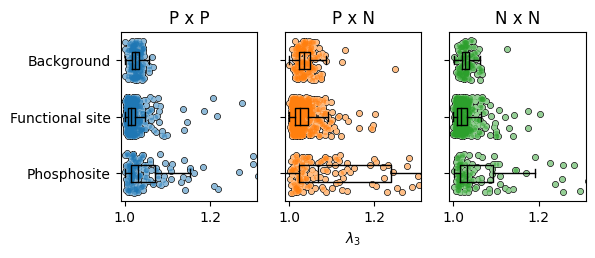

In [13]:
fig = plt.figure(figsize=(6, 2.2), dpi=100)

# Iterate over the 3 comparison types: "PP", "PN", "NN"
for i in range(3):
    ax = fig.add_subplot(1, 3, i + 1)  # Add subplot to figure

    # Extract non-NaN values for each group
    x1 = psite_l3[~np.isnan(np.array(psite_l3[:, i], dtype=float)), i]      # Phosphosites
    x2 = fsite_l3[~np.isnan(np.array(fsite_l3[:, i], dtype=float)), i]      # Functional sites
    x3 = bground_l3[~np.isnan(np.array(bground_l3[:, i], dtype=float)), i]  # Background
    xs = [x1, x2, x3]

    # Plot each group as scattered points with jitter
    for j, x in enumerate(xs):
        y_jitter = (j + 1) + (np.random.rand(len(x)) * 0.7 - 0.35)  # Add vertical jitter
        fancy_scatter(ax, x, y_jitter, color="C" + str(i), size=15, lw=1, alpha=0.5)

    # Overlay boxplot on top of scatter points
    box_plot = ax.boxplot(xs, 0, "", 0)
    for median in box_plot['medians']:
        median.set_color('black')

    # Set x-axis limits
    ax.set_xlim(0.99, 1.31)

    # Add title using comparison label
    ax.set_title(f"{comparison_label[i][0]} x {comparison_label[i][1]}")

    # Add x-axis label only to the middle plot
    if i == 1:
        ax.set_xlabel(r"$\lambda_3$")

    # Set y-tick labels only on the first subplot
    if i == 0:
        ax.set_yticks([1, 2, 3])
        ax.set_yticklabels(["Phosphosite", "Functional site", "Background"])
    else:
        ax.set_yticks([1, 2, 3])
        ax.set_yticklabels([""] * 3)

plt.show()
        

## Strain analysis per comparison group and per protein region - Bootstrap

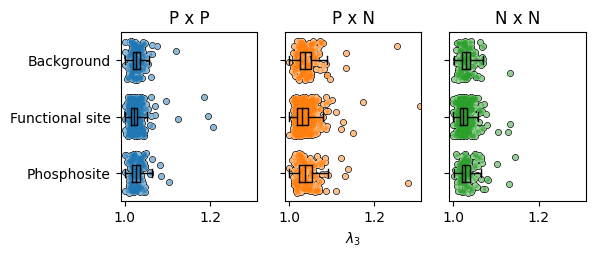

In [14]:
fig = plt.figure(figsize=(6, 2.2), dpi=100)

# Loop over the 3 comparison types (e.g., PP, PN, NN)
for i in range(3):
    ax = fig.add_subplot(1, 3, i + 1)  # Create subplot i+1 in the figure

    # Extract mean values across bootstrap samples, avoiding NaNs
    # For each data type (phosphosite, functional site, background)
    
    x1 = np.mean(psite_bts[~np.isnan(psite_bts[:, i, 0]), i], axis=1)     # Phosphosites
    x2 = np.mean(fsite_bts[~np.isnan(fsite_bts[:, i, 0]), i], axis=1)     # Functional sites
    x3 = np.mean(bground_bts[~np.isnan(bground_bts[:, i, 0]), i], axis=1) # Background
    xs = [x1, x2, x3]  # List of all data series

    # Plot each group as scattered points with jitter
    for j, x in enumerate(xs):
        y = (j + 1) + (np.random.rand(len(x)) * 0.7 - 0.35)
        fancy_scatter(ax, x, y, color="C" + str(i), size=15, lw=1, alpha=0.5)

    # Overlay boxplot on top of scatter points
    box_plot = ax.boxplot(xs, 0, "", 0)
    for median in box_plot['medians']:
        median.set_color('black') 
        
    # Set x-axis limits
    ax.set_xlim(0.99, 1.31)

    # Add title using comparison label
    ax.set_title(f"{comparison_label[i][0]} x {comparison_label[i][1]}")

    # Add x-axis label only to the middle plot
    if i == 1:
        ax.set_xlabel(r"$\lambda_3$")

    # Set y-tick labels only on the first subplot
    if i == 0:
        ax.set_yticks([1, 2, 3])
        ax.set_yticklabels(["Phosphosite", "Functional site", "Background"])
    else:
        ax.set_yticks([1, 2, 3])
        ax.set_yticklabels([""] * 3)

plt.show()

## Strain analysis - PxN results and bootstraps

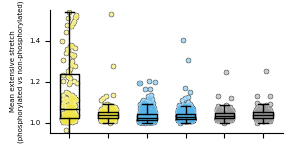

In [17]:
fig = plt.figure(figsize=(3, 1.6), dpi=100)
ax = fig.add_subplot(1, 1, 1)

# Prepare data for the "PN" comparison (index 1)

# Phosphosites
idx = ~np.isnan(psite_l3[:, 1].astype(float))     # Valid entries
x1 = psite_l3[idx, 1]                             # Observed
x1b = np.mean(psite_bts[idx, 1], axis=1)          # Bootstrapped

# Functional Sites
idx = ~np.isnan(fsite_l3[:, 1].astype(float))
x2 = fsite_l3[idx, 1]
x2b = np.mean(fsite_bts[idx, 1], axis=1)

# Background
idx = ~np.isnan(bground_l3[:, 1].astype(float))
x3 = bground_l3[idx, 1]
x3b = np.mean(bground_bts[idx, 1], axis=1)

# Combine data and settings
xs = [x1, x1b, x2, x2b, x3, x3b]  # List of all groups to plot
cs = [                          # Corresponding colors
    "#f0e442", "#f0e442",       # Yellow for phosphosites
    "#56b4e9", "#56b4e9",       # Blue for functional sites
    "#999999", "#999999"        # Gray for background
]

# Plot scatter points for each group
for j, x in enumerate(xs):
    # Add jitter to x-positions
    x_pos = (j + 1) + (np.random.rand(len(x)) * 0.4 - 0.2)
    fancy_scatter(ax, x_pos, x, color=cs[j], size=10, lw=0.7, alpha=0.5)

# Add boxplots on top 
box_plot = ax.boxplot(xs, 0, "", 0.8)
for median in box_plot['medians']:
    median.set_color('black') 
    
# Plot formatting
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylim(0.95, 1.55)

# No x-tick labels to avoid clutter
ax.set_xticks(range(1, len(xs) + 1), [""] * len(xs))

# Y-axis labeling
ax.set_yticks([1.0, 1.2, 1.4])
ax.set_yticklabels(["1.0", "1.2", "1.4"], fontsize=5)
ax.set_ylabel( "Mean extensive stretch\n(phosphorylated vs non-phosphorylated)", fontsize=5)

plt.show()

## Statistical tests with strain analysis

In [16]:
print("Testing the difference between groups: Data x Bootstrap")
print(kruskal(*xs)) 
test = wilcoxon(x1, x1b)
print(test.pvalue)
test = wilcoxon(x2, x2b)
print(test.pvalue)
test = wilcoxon(x3, x3b)
print(test.pvalue)

print("\nTesting the difference between regions of interest: Psite and Fsite x Background")
test = mannwhitneyu(x1, x3)
print(test.pvalue)
test = mannwhitneyu(x2, x3)
print(test.pvalue)


Testing the difference between groups: Data x Bootstrap
KruskalResult(statistic=125.88053073241453, pvalue=1.780144040505112e-25)
1.9949722084370668e-13
0.002556842072293133
5.603315328632851e-17

Testing the difference between regions of interest: Psite and Fsite x Background
9.454847737876325e-07
1.6924349769140637e-07


## Strain analysis - Correlations

In [18]:
# Preparing data for the corelations
psite_l3_per_group = np.zeros(fsite_l3.shape)
bground_l3_per_group = np.zeros(fsite_l3.shape)

# Loop through each phosphosite
for i, psite in enumerate(psites):
    res = int(psite.split("_")[1])
    protein = psite.split("_")[0]

    # Proceed only if this protein is annotated
    if protein in annot_uni:
        data_prot = annot[annot["uniprot_id"] == protein]

        # Retrieve the group IDs for all annotated sites in this protein
        groups = list(set(data_prot["site_idx"]))

        # Get unique index of this protein in the annotation dataframe
        uni_idx = data_prot["uniprot_idx"].iloc[0]
    else:
        continue  
        
    # Fill in λ₃ values for each comparison label and functional group
    for j, label in enumerate(comparison_label):
        for g, group in enumerate(groups):
            psite_l3_per_group[group, j] = psite_l3[i, j]
            bground_l3_per_group[group, j] = bground_l3[i, j]
        

PearsonRResult(statistic=0.23633877439007467, pvalue=0.0014470901016729741)


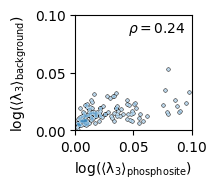

In [19]:
data_bp = [np.log10(psite_l3), 
           np.log10(fsite_l3), 
           np.log10(bground_l3)]

fig = plt.figure(figsize=(1.5, 1.5), dpi=100)
ax = fig.add_subplot(1, 1, 1)

# Choose comparison index (e.g., "PN" if i = 1)
i = 1

# Filter out rows where phosphosite or background values are NaN
idx = ~(np.isnan(data_bp[0][:, i]) + np.isnan(data_bp[2][:, i]))

# Scatter plot: phosphosite vs background λ₃ (log-transformed)
fancy_scatter(
    ax, 
    data_bp[0][idx, i],   # x-axis: phosphosite log λ₃
    data_bp[2][idx, i],   # y-axis: background log λ₃
    "C0", size=5, lw=0.7, alpha=0.3
)

# Compute and display Pearson correlation coefficient
corr = np.corrcoef(data_bp[0][idx, i], data_bp[2][idx, i])
print(pearsonr(data_bp[0][idx, i], data_bp[2][idx, i]))  # Also print detailed stats
ax.text(0.045, 0.085, "$\\rho = $" + str(np.round(corr[0][1], 2)))  # Display ρ in the plot

# Axis formatting
ax.set_xticks([0, 0.05, 0.1])
ax.set_yticks([0, 0.05, 0.1])
ax.set_xlabel("$\\rm log({\\langle \\lambda_3 \\rangle}_{phosphosite})$")
ax.set_ylabel("$\\rm log({\\langle \\lambda_3 \\rangle}_{background})$")
ax.set_xlim(0, 0.1)
ax.set_ylim(0, 0.1)

plt.show()

PearsonRResult(statistic=0.13765572478878352, pvalue=0.0038962565790399014)


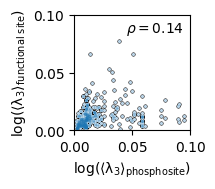

In [22]:
data_bp = [np.log10(psite_l3_per_group), 
           np.log10(fsite_l3), 
           np.log10(bground_l3_per_group)]

fig = plt.figure(figsize=(1.5, 1.5), dpi=100)
ax = fig.add_subplot(1, 1, 1)

# Use the second comparison (index 1, i.e., "PN")
i = 1

# Select valid indices where both phosphosite and functional site values are not NaN
idx = ~(np.isnan(data_bp[0][:, i]) + np.isnan(data_bp[1][:, i]))

# Scatter plot: phosphosite vs functional site log-transformed λ₃ values
fancy_scatter(
    ax,
    data_bp[0][idx, i],  # x-axis: phosphosite
    data_bp[1][idx, i],  # y-axis: functional site
    "C0",                # color
    size=5,
    lw=0.7,
    alpha=0.3
)

# Calculate and display Pearson correlation
corr = np.corrcoef(data_bp[0][idx, i], data_bp[1][idx, i])
print(pearsonr(data_bp[0][idx, i], data_bp[1][idx, i]))  # Print correlation stats
ax.text(0.045, 0.085, "$\\rho = $" + str(np.round(corr[0][1], 2)))  # Add to plot

# Axis formatting
ax.set_xticks([0, 0.05, 0.1])
ax.set_yticks([0, 0.05, 0.1])
ax.set_xlabel("$\\rm log({\\langle \\lambda_3 \\rangle}_{phosphosite})$")
ax.set_ylabel("$\\rm log({\\langle \\lambda_3 \\rangle}_{functional\\ site})$")
ax.set_xlim(0, 0.1)
ax.set_ylim(0, 0.1)

plt.show()

PearsonRResult(statistic=0.32078591026960634, pvalue=6.11513984597268e-12)


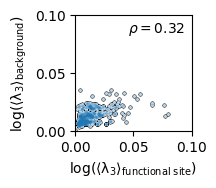

In [23]:
data_bp = [np.log10(psite_l3_per_group), 
           np.log10(fsite_l3), 
           np.log10(bground_l3_per_group)]

fig = plt.figure(figsize = (1.5, 1.5), dpi = 100)
ax = fig.add_subplot(1,1,1)

# Choose comparison type (index 1 corresponds to "PN")
i = 1

# Identify entries with valid (non-NaN) values in both functional and background sets
idx = ~(np.isnan(data_bp[1][:, i]) + np.isnan(data_bp[2][:, i]))

# Scatter plot: functional site vs background
fancy_scatter(
    ax,
    data_bp[1][idx, i],  # x-axis: functional site
    data_bp[2][idx, i],  # y-axis: background
    "C0",                # color
    size=5,
    lw=0.7,
    alpha=0.3
)

# Calculate Pearson correlation and display it
corr = np.corrcoef(data_bp[1][idx, i], data_bp[2][idx, i])
print(pearsonr(data_bp[1][idx, i], data_bp[2][idx, i]))  # Console output
ax.text(0.045, 0.085, "$\\rho = $" + str(np.round(corr[0][1], 2)))  # Plot annotation

# Axes formatting
ax.set_xticks([0, 0.05, 0.1])
ax.set_yticks([0, 0.05, 0.1])
ax.set_xlabel("$\\rm log({\\langle \\lambda_3 \\rangle}_{functional\\ site})$")
ax.set_ylabel("$\\rm log({\\langle \\lambda_3 \\rangle}_{background})$")
ax.set_xlim(0, 0.1)
ax.set_ylim(0, 0.1)

plt.show()

## Strain analysis - Protein families with signifficant deformation in Fsite, Psite, and both


PP
P00489:Binding site::AMP P00489_15
P00517:Binding site::ATP P00517_11
P05132:Binding site::ATP P05132_11
P07949:Site:Cleavage: P07949_905
P07949:Site:Breakpoint for translocation to form PCM1-RET: P07949_905
P12928:Binding site::substrate P12928_144
P17612:Binding site::ATP P17612_11
P28482:Binding site::ATP P28482_185
P28482:Binding site::ATP P28482_187
P31751:Binding site::ATP P31751_451
P48730:Binding site::ATP P48730_220
Q13153:Binding site::ATP Q13153_423
Q13523:Binding site::ATP Q13523_849
Q16539:Binding site::ATP Q16539_180
Q9NWZ3:Binding site::ATP Q9NWZ3_342
Valid pairs: 557
Pie slice sizes: [116, 39, 15, 387]
Significant phosphosites (%): 0.16725978647686832
Unique proteins: 190

PN
B1L3C9:Binding site::Mg(2+) B1L3C9_254
D3KVM3:Binding site::ADP D3KVM3_12
D3KVM3:Binding site::ADP D3KVM3_276
O14920:Binding site::ATP O14920_181
P00517:Binding site::ATP P00517_11
P05132:Binding site::ATP P05132_11
P05132:Binding site::ATP P05132_339
P08200:Binding site::NADP(+) P08200_113
P08

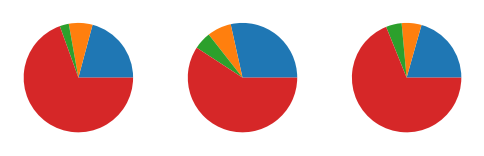

In [25]:
fig = plt.figure(figsize=(6, 2), dpi=100)

# For tracking different categories across comparison types
valid_groups = [[], [], []]
str_both_g = [[], [], []]  # Functional site & phosphosite enriched
str_fsite_g = [[], [], []] # Functional site enriched

# Loop over 3 comparison types: PP, PN, NN
for k, label in enumerate(comparison_label):
    ax = fig.add_subplot(1, 3, k + 1)
    print("\n" + label)

    # Scatter data & color classification
    psite_fc = []
    fsite_fc = []
    color_fc = []

    prot_list = []

    # Count significant phosphosite shifts
    psite_p = 0
    psite_t = 0

    for i, psite in enumerate(psites):
        res = int(psite.split("_")[1])
        protein = psite.split("_")[0]
        
        # Skip if protein not in annotated set
        if protein not in annot_uni:
            continue
        
        data_prot = annot[annot["uniprot_id"] == protein]
        groups = list(set(data_prot["site_idx"]))
        prot_list.append(protein)
        
        # Z-score normalization of phosphosite and group-wise functional site λ₃
        x = (psite_l3[i, k] - np.nanmean(psite_bts[i, k])) / np.nanstd(psite_bts[i, k])
        y = (fsite_l3[groups, k] - np.nanmean(fsite_bts[groups, k], axis=1)) / np.nanstd(fsite_bts[groups, k], axis=1)

        psite_fc += [x] * len(groups)
        fsite_fc += list(y)

        # Significance threshold: z > 3
        xt = x > 3 
        yt = y > 3 

        psite_t += 1
        if xt:
            psite_p += 1

        for g in range(len(groups)):
            if xt and not yt[g]:
                color_fc += ["C0"]
            elif not xt and yt[g]:
                color_fc += ["C1"]
                str_fsite_g[k].append(groups[g])
            elif xt and yt[g]:
                color_fc += ["C2"]
                str_both_g[k].append(groups[g])
                str_fsite_g[k].append(groups[g])
                print(data_prot[data_prot["site_idx"] == groups[g]].iloc[0, 5], psite)
            else:
                color_fc += ["C3"]

            if not np.isnan(y[g]) and not np.isnan(x):
                valid_groups[k].append(groups[g])

    # Filter complete data points
    idx = np.sum(np.isnan(list(zip(psite_fc, fsite_fc))), axis=1) == 0
    print("Valid pairs:", sum(idx))

    # Count each color category for pie chart
    pie_sizes = [np.sum([t == "C" + str(j) for t in np.array(color_fc)[idx]]) for j in range(4)]
    print("Pie slice sizes:", pie_sizes)
    
    # Plot pie chart
    ax.pie(pie_sizes)

    # Report proportion of significantly stretched phosphosites
    print("Significant phosphosites (%):", psite_p / psite_t)
    print("Unique proteins:", len(set(prot_list)))

plt.show()

## Enrichment test 

Use a hypergeometric test for enrichment of types of functional sites co-strained with the phosphosite

In [29]:
# Initialize containers for results per comparison (PP, PN, NN)
valid_fsite = [[], [], []]   # All valid functional sites with non-NaN values
str_fsite = [[], [], []]     # Functional sites with significant λ₃ deformation only
str_both = [[], [], []]      # Functional sites with significant deformation both at psite and fsite

# Loop over the three comparison groups
for j in range(3):
    # For all valid functional site groups in this comparison
    for g in valid_groups[j]:
        # Extract annotation info (assumed residue number) for each group
        residue_index = annot.loc[annot["site_idx"] == g, annot.columns[5]].iloc[0]
        valid_fsite[j].append(residue_index)

    # For functionally stretched sites only
    for g in str_fsite_g[j]:
        residue_index = annot.loc[annot["site_idx"] == g, annot.columns[5]].iloc[0]
        str_fsite[j].append(residue_index)

    # For sites stretched both as phosphosite and functional site
    for g in str_both_g[j]:
        residue_index = annot.loc[annot["site_idx"] == g, annot.columns[5]].iloc[0]
        str_both[j].append(residue_index)

In [31]:
def trim_uniprot(vec):
    """
    Trims the uniprot identifiers by splitting the string at the ':' character
    and reassembling the remaining parts after the first split.

    Parameters:
        vec (list of str): List of uniprot identifiers (strings)
    
    Returns:
        list of str: A list of cleaned uniprot identifiers.
    """
    res = []
    for x in vec:
        x = x.split(":")[1:]  # Split by ":" and skip the first part
        t = ""
        for i in x:
            t += i + ":"  # Reassemble the parts with ":" separator
        res.append(t)
    return res

# Prepare the trimmed datasets for hypergeometric test
dataset_hg = trim_uniprot(valid_fsite[1])  # Prepare dataset of valid functional sites
sampled_hg = trim_uniprot(str_both[1])     # Prepare dataset of sites that are both phosphosite and functional site

M = len(dataset_hg)  # Total number of entries in the dataset (M)
N = len(sampled_hg)  # Total number of entries in the sampled group (N)
nrep = len(np.unique(dataset_hg))  # Number of unique elements in the dataset

# Loop through each unique element in the dataset
for uniq in np.unique(dataset_hg):
    n = dataset_hg.count(uniq)  # Number of occurrences of `uniq` in the dataset
    k = sampled_hg.count(uniq)  # Number of occurrences of `uniq` in the sampled group
    
    # Calculate the p-value of the hypergeometric test (survival function)
    pval = hypergeom.sf(k, M=M, n=n, N=N) < .05 / nrep  # Adjusted p-value with multiple comparisons correction
    
    if pval:
        # Print the unique element, its p-value, and the counts of occurrences in both datasets
        print(uniq, pval, dataset_hg.count(uniq), sampled_hg.count(uniq))
        # Print the raw p-value for hypergeometric test
        print(hypergeom.sf(k, M=M, n=n, N=N))

Binding site::ATP: True 102 21
6.6595911850302655e-12
Site:Interaction with PLC-gamma-1:: True 1 1
0.0


## Shortest distance between P-site and F-site

In [34]:
def shortest_dist_pfsite(pres, fres, psite):
    """
    Calculates the shortest pairwise distance between a reference residue (pres) and
    a set of functional residues (fres) for a given phosphosite (psite), using precomputed
    distance matrices.

    Parameters:
        pres (int): Index of the reference residue.
        fres (list of int): List of indices of functional residues.
        psite (str): Phosphosite identifier used to locate relevant distance files.

    Returns:
        tuple: A tuple containing the median and minimum distance between the reference residue
               and the functional residues, or [np.nan] if no valid distance is found.
    """
    # Retrieve the accessions associated with the given phosphosite
    accessions = protN_accession[psite] + protP_accession[psite]

    # Initialize a list to store the shortest distances for each accessions file
    shortest = []

    # Iterate over each accession to check the corresponding distance matrix
    for accession in accessions:
        # Define the file path for the distance matrix
        file = "data/server/output_pdist/" + accession + "_pdist.npy"
        
        # Skip the file if it doesn't exist
        if not os.path.exists(file):
            continue
        
        # Load the distance vector from the file
        vector = np.load(file)

        # Calculate the number of residues from the length of the vector
        nres = (1 + 8*vector.shape[0])**.5/2 - 1/2
        nres = int(nres)  # Convert to integer

        # Extract the residue indices and the pairwise distance matrix
        idx = vector[:nres].tolist()
        pdist = squareform(vector[nres:])  # Convert flat vector to a distance matrix

        # Check if the reference residue (pres) exists in the distance matrix
        if pres in idx:
            fres_in = False     # Flag to check if any functional residue is in the matrix
            min_dist = np.inf   # Initialize the minimum distance as infinity
            i = idx.index(pres) # Get the index of the reference residue

            # Iterate over the functional residues to find the shortest distance
            for fres_j in fres:
                if fres_j in idx:  # Check if the functional residue exists in the matrix
                    fres_in = True
                    j = idx.index(fres_j)  # Get the index of the functional residue

                    # Update the minimum distance if a shorter distance is found
                    if pdist[i, j] < min_dist:
                        min_dist = pdist[i, j]

            # If a valid functional residue was found, add the minimum distance to the list
            if fres_in:
                shortest.append(min_dist)

    # Return the median and minimum distances, or np.nan if no valid distances were found
    if len(shortest):
        return np.median(shortest), np.min(shortest)
    return [np.nan]


PP
P00489:Binding site::AMP 	psite: 15 	shortest dist: 31.6
[43, 76, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319]
P00517:Binding site::ATP 	psite: 11 	shortest dist: 27.9
[50, 51, 52, 53, 54, 55, 56, 57, 58, 73, 122, 123, 124, 125, 126, 127, 128, 169, 170, 171, 172]
P05132:Binding site::ATP 	psite: 11 	shortest dist: 28.3
[50, 51, 52, 53, 54, 55, 56, 57, 58, 73, 122, 123, 124, 125, 126, 127, 128, 169, 170, 171, 172]
P07949:Site:Cleavage: 	psite: 905 	shortest dist: 23.7
[707, 708]
P07949:Site:Breakpoint for translocation to form PCM1-RET: 	psite: 905 	shortest dist: 26.8
[712, 713]
P12928:Binding site::substrate 	psite: 144 	shortest dist: 48.1
[116]
P17612:Binding site::ATP 	psite: 11 	shortest dist: 28.1
[50, 51, 52, 53, 54, 55, 56, 57, 58, 73, 122, 123, 124, 125, 126, 127, 128, 169, 170, 171, 172]
P28482:Binding site::ATP 	psite: 185 	shortest dist: 22.7
[31, 32, 33, 34, 35, 36, 37, 38, 39, 54]
P28482:Binding site::ATP 	psite: 187 	shortest dist: 16.2
[31, 32, 33, 34, 35, 36, 

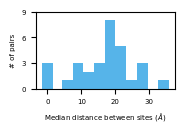

In [36]:
fig = plt.figure(figsize=(1.8, 1.), dpi=100)

# Loop through each comparison label (e.g., different experimental conditions or groups)
for k, label in enumerate(comparison_label):
    print("\n" + label)

    # Initialize lists to store data for plotting
    psite_fc = []  # List to store normalized data for psite
    fsite_fc = []  # List to store normalized data for fsite

    # List of shortest paths
    co_strained_sp = []      # Co-strained phosphosites (Z > 3)
    not_co_strained_sp = []  # Non-co-strained phosphosites (Z <= 3)

    prot_list = []  # List to track proteins in the analysis

    # Counters for phosphosites with large Z-scores
    psite_p = 0  # Counter for phosphosites that pass the threshold
    psite_t = 0  # Total number of phosphosites processed
    
    # Loop over each psite in the dataset
    for i, psite in enumerate(psites):
        res = int(psite.split("_")[1]) # Extract residue index from psite
        protein = psite.split("_")[0]  # Extract protein identifier from psite
        
        # Check if protein exists in the annotation data
        if protein in annot_uni:
            data_prot = annot[annot["uniprot_id"] == protein]
            groups = list(set(data_prot["site_idx"]))  # List of site indices for the protein
            prot_list.append(protein)  # Add protein to the list
                    
            # Normalize the psite and fsite data (Z-score)
            x = (psite_l3[i, k] - np.nanmean(psite_bts[i, k])) / np.nanstd(psite_bts[i, k])
            y = (fsite_l3[groups, k] - np.nanmean(fsite_bts[groups, k], axis=1)) / np.nanstd(fsite_bts[groups, k], axis=1)

            # Append the normalized data to the respective lists
            psite_fc += [x] * len(groups)
            fsite_fc += list(y)

            # Check if the normalized values exceed the threshold (3 standard deviations)
            xt = x > 3  # psite is considered strained if > 3 std dev
            yt = y > 3  # fsite is considered strained if > 3 std dev

            # Update counters for phosphosites passing the threshold
            psite_t += 1
            if xt == 1:
                psite_p += 1

            # Loop over each group to compute the shortest distance between residues
            for g in range(len(groups)):
                if xt == 1 and yt[g] == 1:  # Only consider pairs where both psite and fsite are strained
                    fres = list(data_prot[data_prot["site_idx"] == groups[g]]["residue"])  # Get residues for functional site
                    sp = shortest_dist_pfsite(res, fres, psite)  # Calculate the shortest distance

                    # Print detailed information about the strained phosphosite
                    print(data_prot[data_prot["site_idx"] == groups[g]].iloc[0, 5], "\tpsite:", res, "\tshortest dist:", np.round(sp[0], 1))
                    print(fres)
                    
                    co_strained_sp.append(sp[0])  # Append the shortest distance for co-strained phosphosites

    # Only plot the histogram for the second comparison label (k == 1)
    if k == 1:
        ax = fig.add_subplot(1, 1, 1)

        # Convert the list of distances to a numpy array for processing
        co_strained_sp = np.array(co_strained_sp)

        # Plot histogram for non-zero distances
        hist = plt.hist(co_strained_sp[co_strained_sp != 0], color="#56b4e9")
        bin_size = hist[1][1] - hist[1][0]  # Calculate the bin size

        # Plot histogram for zero distances separately (using a smaller bin size)
        plt.hist(co_strained_sp[co_strained_sp == 0], bins=[-bin_size/2, bin_size/2], color="#56b4e9")

        # Set the labels and ticks for the x and y axes
        plt.xlabel("Median distance between sites ($\\AA$)", fontsize=5)
        plt.xticks([0, 10, 20, 30], fontsize=5)
        plt.ylabel("# of pairs", fontsize=5)
        plt.yticks([0, 3, 6, 9], fontsize=5)
    
    # Print the mean of the non-zero co-strained distances
    print(np.mean(co_strained_sp[co_strained_sp != 0]))

    # Check for and print the count of valid data pairs (where neither psite_fc nor fsite_fc is NaN)
    idx = np.sum(np.isnan(list(zip(psite_fc, fsite_fc))), axis=1) == 0
    print(sum(idx))

plt.show()

## Correlation dimension at the whole protein scale

In [46]:
# Initialize arrays to store statistics: min correlation, protein correlation, number of residues, and fraction of residues
# All arrays are initialized with NaN values for each psite and comparison label
min_corr = np.zeros((len(psites), 3)) * np.nan  # Minimum correlation for each psite and label
prot_corr = np.zeros((len(psites), 3)) * np.nan  # Protein correlation for each psite and label
min_numres = np.zeros((len(psites), 3)) * np.nan  # Minimum number of residues for each psite and label
min_fracres = np.zeros((len(psites), 3)) * np.nan  # Minimum fraction of residues for each psite and label

# Loop over all phosphosites to compute the statistics
for i, psite in enumerate(psites):
    res = int(psite.split("_")[1])  # Extract residue index from psite (e.g., from "protein_residue")
    protein = psite.split("_")[0]  # Extract protein identifier from psite
    
    # Check if the protein exists in the annotation (annot_uni) dataset
    if protein in annot_uni:
        
        # Loop over each comparison label to calculate correlation dimension statistics for each comparison
        for j, label in enumerate(comparison_label):
            
            # Skip if the value in the is_nan array for this psite and label is True (i.e., the data is missing)
            if not is_nan[i, j]:
                
                # Load the comparison data for the current psite and label (correlation dimension data)
                file = "data/server/output_cd/" + psite + "_" + label + ".npy"
                all_comparisons = np.load(file, allow_pickle=True)  # Load all comparison data for this psite and label
                
            else:
                continue  # Skip if data is missing for this psite and label

            # Initialize lists to hold statistics for the current psite and label
            corr = []  # List to store minimum correlation values for each comparison
            protcorr = []  # List to store protein correlation values for each comparison
            numres = []  # List to store the number of residues for each comparison
            fracres = []  # List to store the fraction of residues for each comparison

            # Loop over all comparisons for the current psite and label
            for c, comp in enumerate(all_comparisons):
                comp = comp[0]  # Get the first element of the comparison (usually the correlation dimension data)
                
                # Calculate statistics for the current comparison
                corr.append(np.min(comp))  # Minimum correlation value for this comparison
                protcorr.append(comp[-1])  # Protein correlation value (last element)
                numres.append(np.argmin(comp) + 10)  # Number of residues (where the correlation is minimized)
                fracres.append((np.argmin(comp) + 10) / (len(comp) + 10))  # Fraction of residues involved in the correlation
                
            # Store the mean of the calculated statistics for the current psite and label
            min_corr[i, j] = np.nanmean(corr)  # Store mean minimum correlation
            prot_corr[i, j] = np.nanmean(protcorr)  # Store mean protein correlation
            min_numres[i, j] = np.nanmean(numres)  # Store mean number of residues
            min_fracres[i, j] = np.nanmean(fracres)  # Store mean fraction of residues


KruskalResult(statistic=3.4141016993647817, pvalue=0.181399980339635)
0.611982048885133
0.2303025616265122
0.06212825223248756


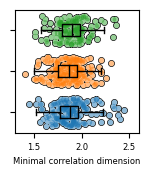

In [48]:
fig = plt.figure(figsize = (1.6, 1.6), dpi = 100)
ax = fig.add_subplot()

# Group the data by removing NaN values from the `min_corr` array for each comparison label
groups = [min_corr[~ np.isnan(min_corr[:, i]),i] for i in range(3)]

# Loop through the groups (for each comparison) to scatter plot the data
for i in range(3):
    fancy_scatter(ax, 
                  groups[i], 
                  (i+1)*np.ones(len(groups[i])) + np.random.rand(len(groups[i])) * 0.7 - 0.35,  # Add random jitter to y-values
                  "C"+str(i),  # Color is assigned based on the comparison group
                  15,  # Marker size
                  1,  # Transparency (alpha)
                  0.5)  # Scatter point transparency

# Create a boxplot to visualize the distribution of data in each group
box_plot = ax.boxplot(groups, 0, "", 0)

# Set the color of the medians in the boxplot to black for better visibility
for median in box_plot['medians']:
    median.set_color('black')

# Perform Kruskal-Wallis H-test to test if there's a statistically significant difference between the groups
print(kruskal(*groups))

# Perform pairwise Mann-Whitney U tests between the groups to compare differences between each pair
test = mannwhitneyu(groups[0], groups[1])  # Compare group 1 vs group 2
print(test.pvalue)
test = mannwhitneyu(groups[0], groups[2])  # Compare group 1 vs group 3
print(test.pvalue)
test = mannwhitneyu(groups[1], groups[2])  # Compare group 2 vs group 3
print(test.pvalue)

# Set labels and formatting for the plot
ax.set_xlabel("Minimal correlation dimension", fontsize = 6)  # Set x-axis label
ax.set_ylabel("")  
plt.xticks([1.5, 2, 2.5], fontsize = 6) 
ax.set_yticks([1, 2, 3], [""]*3) 
ax.set_xlim(1.3, 2.6) 
plt.show()

KruskalResult(statistic=1.928969127185807, pvalue=0.38117962296846813)
0.15870607712277562
0.4340758743345885
0.6441817238896914


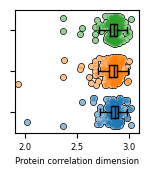

In [49]:
fig = plt.figure(figsize = (1.6, 1.6), dpi = 100)
ax = fig.add_subplot()

# Group the data by removing NaN values from the `prot_corr` array for each comparison label
groups = [prot_corr[~ np.isnan(prot_corr[:, i]),i] for i in range(3)]

# Loop through the groups (for each comparison) to scatter plot the data
for i in range(3):
    fancy_scatter(ax, 
                  groups[i], 
                  (i+1)*np.ones(len(groups[i])) + np.random.rand(len(groups[i])) * 0.7 - 0.35,  # Add random jitter to y-values
                  "C"+str(i),  # Color is assigned based on the comparison group
                  15,  # Marker size
                  1,  # Transparency (alpha)
                  0.5)  # Scatter point transparency

# Create a boxplot to visualize the distribution of data in each group
box_plot = ax.boxplot(groups, 0, "", 0)

# Set the color of the medians in the boxplot to black for better visibility
for median in box_plot['medians']:
    median.set_color('black')

# Perform Kruskal-Wallis H-test to test if there's a statistically significant difference between the groups
print(kruskal(*groups))

# Perform pairwise Mann-Whitney U tests between the groups to compare differences between each pair
test = mannwhitneyu(groups[0], groups[1])  # Compare group 1 vs group 2
print(test.pvalue)
test = mannwhitneyu(groups[0], groups[2])  # Compare group 1 vs group 3
print(test.pvalue)
test = mannwhitneyu(groups[1], groups[2])  # Compare group 2 vs group 3
print(test.pvalue)

# Set labels and formatting for the plot
ax.set_xlabel("Protein correlation dimension", fontsize = 6)  # Set x-axis label
ax.set_ylabel("") 
plt.xticks([2, 2.5, 3], fontsize = 6) 
ax.set_yticks([1, 2, 3], [""]*3) 
ax.set_xlim(1.9, 3.1)
plt.show()

KruskalResult(statistic=3.467433678182927, pvalue=0.1766266954113736)
0.534934107083362
0.24248731121680356
0.061841579803300906


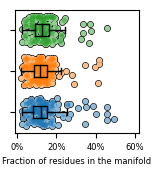

In [50]:
fig = plt.figure(figsize = (1.6, 1.6), dpi = 100)
ax = fig.add_subplot()

# Group the data by removing NaN values from the `min_fracres` array for each comparison label
groups = [min_fracres[~ np.isnan(min_fracres[:, i]),i] for i in range(3)]

# Loop through the groups (for each comparison) to scatter plot the data
for i in range(3):
    fancy_scatter(ax, 
                  groups[i], 
                  (i+1)*np.ones(len(groups[i])) + np.random.rand(len(groups[i])) * 0.7 - 0.35,  # Add random jitter to y-values
                  "C"+str(i),  # Color is assigned based on the comparison group
                  15,  # Marker size
                  1,  # Transparency (alpha)
                  0.5)  # Scatter point transparency

# Create a boxplot to visualize the distribution of data in each group!
box_plot = ax.boxplot(groups, 0, "", 0)

# Set the color of the medians in the boxplot to black for better visibility
for median in box_plot['medians']:
    median.set_color('black')

# Perform Kruskal-Wallis H-test to test if there's a statistically significant difference between the groups
print(kruskal(*groups))

# Perform pairwise Mann-Whitney U tests between the groups to compare differences between each pair
test = mannwhitneyu(groups[0], groups[1])  # Compare group 1 vs group 2
print(test.pvalue)
test = mannwhitneyu(groups[0], groups[2])  # Compare group 1 vs group 3
print(test.pvalue)
test = mannwhitneyu(groups[1], groups[2])  # Compare group 2 vs group 3
print(test.pvalue)

# Set labels and formatting for the plot
ax.set_xlabel("Fraction of residues in the manifold", fontsize = 6)
ax.set_ylabel("") 
plt.xticks([0, .2, .4, .6], ["0%", "20%", "40%", "60%"], fontsize = 6)
ax.set_yticks([1, 2, 3], [""]*3) 
ax.set_xlim(-0.01, 0.62)
plt.show()

## Calculating data for high strain manifold - Phosphosite and functional site

In [51]:
def mean_overlap(all_comparisons, res, groups, random=False, seed=0):
    """
    Computes the mean overlap between residues belonging to the high strain manifold, defined as the
    subset of residues with increasing size (sorted by strain) that yields the minimal correlation
    dimension.

    Parameters:
    - all_comparisons (list): A list of tuples, each representing one comparison.
                              Each tuple contains:
                                - comp[0]: correlation dimension per residue
                                - comp[1]: strain per residue
                                - comp[2]: list of residue indices 
    - res (int): The residue number corresponding to the phosphosite of interest.
    - groups (list): A list of group indices corresponding to functional site groupings.
    - random (bool): If True, randomly shuffles the ranking vector before selecting top residues.
    - seed (int): Random seed used for reproducibility when random shuffling is enabled.

    Returns:
    - mean_psite_overlap (float): Mean overlap fraction between top-ranked residues and the phosphosite.
    - mean_fsite_overlap_list (list of float): Mean overlap fractions for each functional site group.
    """

    # Initialize temporary lists to accumulate overlap scores
    fsite_temp = [[] for _ in groups]  # Stores overlaps for each functional site group
    psite_temp = []                    # Stores overlaps for the phosphosite

    # Iterate over all comparisons within a protein
    for c, comp in enumerate(all_comparisons):
        if isinstance(comp, tuple):
            # Optionally shuffle the correlation dimension rankings
            if random:
                np.random.seed(seed)
                size = len(comp[1])
                l3 = comp[1][np.random.choice(size, size, replace=False)]
            else:
                l3 = comp[1]

            # Determine the residues within the high strain manifold based on the residue
            # with the minimal correlation dimension
            N = np.argmin(comp[0]) + 10             
            min_cd = set(np.argsort(l3)[::-1][:N])  

            # Determine indices corresponding to the phosphosite and its ±2 residue window
            interval = set(np.where(
                np.sum([x == comp[2] for x in [res - 2, res - 1, res, res + 1, res + 2]], axis=0)
                .astype(bool)
            )[0])

            # Calculate overlap of the phosphosite with high strain manifold
            if len(interval) > 0:
                overlap = len(interval.intersection(min_cd)) / len(interval)
                psite_temp.append(overlap)

            # Compute overlaps for each functional site group with high strain manifold
            for g, group in enumerate(groups):
                data_group = data_prot[data_prot["site_idx"] == group]
                res_group = list(data_group["residue"]) 
                
                # Map group residues to indices within comp[2]
                res_group = set(np.where(
                    np.sum([x == comp[2] for x in res_group], axis=0)
                    .astype(bool)
                )[0])

                # Checking if these residues are part of the solved structure
                if len(res_group) > 0:
                    overlap = len(res_group.intersection(min_cd)) / len(res_group)
                    fsite_temp[g].append(overlap)

    # Return the mean overlap for the phosphosite and the list of mean overlaps for each fsite group
    return np.nanmean(psite_temp), [np.nanmean(group) for group in fsite_temp]

In [53]:
# Initialize output arrays with NaNs for overlap values
# overlap_psite: stores phosphosite overlaps [# psites x # comparisons]
# overlap_fsite: stores functional site overlaps [# fsite groups x # comparisons]
overlap_psite = np.zeros((len(psites), 3)) * np.nan
overlap_fsite = np.zeros((annot_n, 3)) * np.nan

# Iterate over all phosphosites
for i, psite in enumerate(psites):
    # Extract residue index and UniProt ID from psite label
    res = int(psite.split("_")[1])
    protein = psite.split("_")[0]
    
    # Check if the protein has annotated functional sites
    if protein in annot_uni:
        # Extract all annotations for this protein
        data_prot = annot[annot["uniprot_id"] == protein]

        # Get unique site group indices (for functional site groupings)
        groups = list(set(data_prot["site_idx"]))

        # Retrieve corresponding uniprot index
        uni_idx = data_prot["uniprot_idx"].iloc[0]
    else:
        # Skip if no annotation exists
        continue

    # Loop over 3 comparison types: PP, PN, NN
    for j, label in enumerate(comparison_label):
        # Skip if this comparison is marked invalid for this psite
        if not is_nan[i, j]:
            # Load precomputed correlation dimension data for this site
            file = f"data/server/output_cd/{psite}_{label}.npy"
            all_comparisons = np.load(file, allow_pickle=True)
        else:
            continue

        # Compute overlaps for psite and fsites using helper function
        psite_temp, fsite_temp = mean_overlap(all_comparisons, res, groups)

        # Assign overlaps to the appropriate output arrays
        for g, group in enumerate(groups):
            overlap_fsite[group, j] = fsite_temp[g]
        overlap_psite[i, j] = psite_temp

    print(f"Processed phosphosite {i}: UniProt index {uni_idx}")
    
# Save computed overlaps for later visualization
np.save("data/server/output_cd/overlap_psite.npy", overlap_psite)
np.save("data/server/output_cd/overlap_fsite.npy", overlap_fsite)

Processed phosphosite 0: UniProt index 0
Processed phosphosite 2: UniProt index 1
Processed phosphosite 27: UniProt index 2
Processed phosphosite 30: UniProt index 3
Processed phosphosite 31: UniProt index 4
Processed phosphosite 34: UniProt index 5
Processed phosphosite 35: UniProt index 6
Processed phosphosite 37: UniProt index 7
Processed phosphosite 38: UniProt index 7
Processed phosphosite 39: UniProt index 8
Processed phosphosite 45: UniProt index 9
Processed phosphosite 46: UniProt index 10
Processed phosphosite 48: UniProt index 11
Processed phosphosite 49: UniProt index 11
Processed phosphosite 50: UniProt index 11
Processed phosphosite 52: UniProt index 12
Processed phosphosite 53: UniProt index 12
Processed phosphosite 54: UniProt index 13
Processed phosphosite 55: UniProt index 13
Processed phosphosite 56: UniProt index 14
Processed phosphosite 58: UniProt index 15
Processed phosphosite 59: UniProt index 16
Processed phosphosite 60: UniProt index 17
Processed phosphosite 62

In [55]:
# Number of bootstrap resamples
bts_n = 50

# Initialize 3D arrays to hold bootstrapped overlaps
# Dimensions: [# psites x # comparisons x # bootstrap samples]
overlap_psite_bts = np.zeros((len(psites), 3, bts_n)) * np.nan
overlap_fsite_bts = np.zeros((annot_n, 3, bts_n)) * np.nan

# Loop over phosphosites
for i, psite in enumerate(psites):
    # Extract residue number and UniProt ID
    res = int(psite.split("_")[1])
    protein = psite.split("_")[0]
    
    # Skip if protein has no functional annotation
    if protein in annot_uni:
        # Extract all annotations for this protein
        data_prot = annot[annot["uniprot_id"] == protein]

        # Get unique group indices for functional sites
        groups = list(set(data_prot["site_idx"]))        

        # Retrieve corresponding uniprot index
        uni_idx = data_prot["uniprot_idx"].iloc[0]
    else:
        continue

    # Loop over 3 comparison types: PP, PN, NN
    for j, label in enumerate(comparison_label):
        # Skip if flagged as missing or invalid
        if not is_nan[i, j]:
            # Load precomputed correlation dimension data for this site
            file = f"data/server/output_cd/{psite}_{label}.npy"
            all_comparisons = np.load(file, allow_pickle=True)
        else:
            continue

        # Perform bootstrap resampling
        for r in range(bts_n):
            # Compute random-overlap using shuffled strain values
            psite_temp, fsite_temp = mean_overlap(all_comparisons, res, groups, random=True, seed=bts_n * i + r)

            # Store computed overlaps
            for g, group in enumerate(groups):
                overlap_fsite_bts[group, j, r] = fsite_temp[g]
            overlap_psite_bts[i, j, r] = psite_temp    

    print(f"Processed phosphosite {i}: UniProt index {uni_idx}")
    
# Save all bootstrap overlap matrices
np.save("data/server/output_cd/overlap_psite_bts.npy", overlap_psite_bts)
np.save("data/server/output_cd/overlap_fsite_bts.npy", overlap_fsite_bts)

Processed phosphosite 0: UniProt index 0
Processed phosphosite 2: UniProt index 1
Processed phosphosite 27: UniProt index 2
Processed phosphosite 30: UniProt index 3
Processed phosphosite 31: UniProt index 4


KeyboardInterrupt: 

## Manifold analysis: Loading data previously calculated

Here we load the dataset generated in the previous chunks. Because identifying the high strain manifold and calculating the overlaps with sites of interest can be time consuming, especially for the multiple bootstraps, we recommend saving the results and loading them whenever it is needed

In [56]:
overlap_psite = np.load("data/server/output_cd/" + "overlap_psite" + ".npy")
overlap_fsite = np.load("data/server/output_cd/" + "overlap_fsite" + ".npy")

overlap_psite_bts = np.load("data/server/output_cd/" + "overlap_psite_bts" + ".npy")
overlap_fsite_bts = np.load("data/server/output_cd/" + "overlap_fsite_bts" + ".npy")

## Manifold analysis - Percentage of phosphosites residues represented in the high strain manifold

KruskalResult(statistic=7.205014826185428, pvalue=0.027255296409907773)
0.5621025620803646
0.049019752985117925
0.012751903919529909


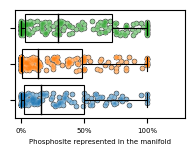

In [34]:
fig = plt.figure(figsize = (2.2, 1.4), dpi = 100)
ax = fig.add_subplot()

# Reorder comparison groups
groups = [overlap_psite[~np.isnan(overlap_psite[:, i]), i] for i in [2, 0, 1]]

# Plot the scatter plot data using customised script
for i in range(3):
    fancy_scatter(ax, groups[i], (i+1)*np.ones(len(groups[i])) + np.random.rand(len(groups[i]))*.4 - .2, "C"+str(i), 10, .7, .5)

# Overlay boxplot on top of the scatter plots
lw = .8
box_plot = ax.boxplot(groups, 0, "", 0, widths = .8, patch_artist = True,
                      boxprops = dict(linewidth = lw, facecolor = "#0000"),
                      whiskerprops = dict(linewidth = lw),
                      capprops = dict(linewidth = lw))
for median in box_plot['medians']:
    median.set_color('black')

# Statistical analyses: Kruskal wallis test among the three datasets
print(kruskal(*groups)) 
# Statistical analyses: Mann Whitney U test to compare individually each pair
test = mannwhitneyu(groups[0], groups[1])
print(test.pvalue)
test = mannwhitneyu(groups[0], groups[2])
print(test.pvalue)
test = mannwhitneyu(groups[1], groups[2])
print(test.pvalue)

# Formatting the figure
ax.set_xlabel("Phosphosite represented in the manifold", fontsize = 5)
ax.set_ylabel("")
plt.xticks([0, .5, 1], ["0%", "50%", "100%"], fontsize = 5)
ax.set_yticks([1, 2, 3], [""]*3)
ax.set_xlim(-0.05, 1.3)
plt.show()

## Manifold analysis - Percentage of functional sites residues represented in the high strain manifold

KruskalResult(statistic=11.712826230613508, pvalue=0.0028614891286337816)
0.0010245359892763833
0.43214657775546783
0.009334315801235251


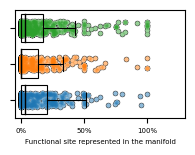

In [35]:
fig = plt.figure(figsize = (2.2, 1.4), dpi = 100)
ax = fig.add_subplot()

# Reorder comparison groups
groups = [overlap_fsite[~np.isnan(overlap_fsite[:, i]), i] for i in [2, 0, 1]]

# Plot the scatter plot data using customised script
for i in range(3):
    fancy_scatter(ax, groups[i], (i+1)*np.ones(len(groups[i])) + np.random.rand(len(groups[i]))*.4 - .2, "C"+str(i), 10, .7, .5)
    
# Overlay boxplot on top of the scatter plots
box_plot = ax.boxplot(groups, 0, "", 0, widths = .8, patch_artist = True,
                      boxprops = dict(linewidth = lw, facecolor = "#0000"),
                      whiskerprops = dict(linewidth = lw),
                      capprops = dict(linewidth = lw))
for median in box_plot['medians']:
    median.set_color('black')

# Statistical analyses: Kruskal wallis test among the three datasets
print(kruskal(*groups)) 
# Statistical analyses: Mann Whitney U test to compare individually each pair
test = mannwhitneyu(groups[0], groups[1])
print(test.pvalue)
test = mannwhitneyu(groups[0], groups[2])
print(test.pvalue)
test = mannwhitneyu(groups[1], groups[2])
print(test.pvalue)

# Formatting the figure
ax.set_xlabel("Functional site represented in the manifold", fontsize = 5)
ax.set_ylabel("")
plt.xticks([0, .5, 1], ["0%", "50%", "100%"], fontsize = 5)
ax.set_yticks([1, 2, 3], [""]*3)
ax.set_xlim(-0.05, 1.3)
plt.show()

## Manifold analysis - PxN including bootstraps

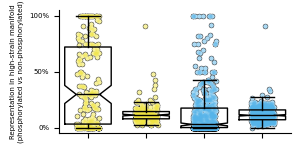

In [61]:
fig = plt.figure(figsize=(3, 1.6), dpi=100)
ax = fig.add_subplot(1, 1, 1)

# Extract p-site overlap values for comparison PxN
x1 = overlap_psite[~np.isnan(np.array(overlap_psite[:, 1], dtype=float)), 1]
# Compute mean overlap over bootstraps
x1b = np.mean(overlap_psite_bts[~np.isnan(np.array(overlap_psite_bts[:, 1, 0], dtype=float)), 1], axis=1)

# Repeat for f-sites
x2 = overlap_fsite[~np.isnan(np.array(overlap_fsite[:, 1], dtype=float)), 1]
x2b = np.mean(overlap_fsite_bts[~np.isnan(np.array(overlap_fsite_bts[:, 1, 0], dtype=float)), 1], axis=1)

# Combine all values for plotting
xs = [x1, x1b, x2, x2b]

# Define colors: yellow for p-sites, blue for f-sites
cs = ["#f0e442", "#f0e442", "#56b4e9", "#56b4e9"] 

# Plot individual data points with jittered y-values
for j, x in enumerate(xs):
    fancy_scatter(
        ax,
        (j + 1) * np.ones(len(x)) + np.random.rand(len(x)) * 0.4 - 0.2,
        x,
        cs[j], 10, 0.7, 0.5
    )

# Overlay boxplot for distributions
box_plot = ax.boxplot(xs, 1, "", widths=0.8)
for median in box_plot['medians']:
    median.set_color('black')

# Simplify plot aesthetics by hiding top/right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)    

# Format x and y ticks and labels
ax.set_xticks(range(1, len(xs)+1), [""] * len(xs))
ax.set_yticks([0, 0.5, 1], ["0%", "50%", "100%"], fontsize=5)
ax.set_ylabel("Representation in high-strain manifold\n(phosphorylated vs non-phosphorylated)", fontsize=5)

plt.show()


## Statistical tests with manifold analysis

In [59]:
print("Global Kruskal-Wallis test comparing all groups")
print(kruskal(*xs)) 

print("\nPaired Wilcoxon tests to compare data and bootstrap")
test = wilcoxon(x1, x1b)
print(test.pvalue)
test = wilcoxon(x2, x2b)
print(test.pvalue)

Global Kruskal-Wallis test comparing all groups
KruskalResult(statistic=129.96394566831006, pvalue=5.5060885860717e-28)

Paired Wilcoxon tests to compare data and bootstrap
7.584558076001902e-14
0.0001672258681608198


## Manifold analysis - Protein families with signifficant overrepresentation of Fsite, Psite, and both in the high strain manifold


PP
B1L3C9:Binding site::CoA B1L3C9_254
B1L3C9:Binding site::acetyl-CoA B1L3C9_254
P00489:Binding site::AMP P00489_15
P00517:Binding site::ATP P00517_11
P05132:Binding site::ATP P05132_11
P06737:Binding site::AMP P06737_15
P07949:Site:Cleavage: P07949_905
P07949:Site:Breakpoint for translocation to form PCM1-RET: P07949_905
P12928:Binding site::substrate P12928_144
P12931:Binding site::ATP P12931_419
P17612:Binding site::ATP P17612_11
P28482:Binding site::ATP P28482_185
P31751:Binding site::ATP P31751_451
P48730:Binding site::ATP P48730_220
Q13153:Binding site::ATP Q13153_423
Q13523:Binding site::ATP Q13523_849
Q16539:Binding site::ATP Q16539_180
Q16539:Binding site::ATP Q16539_182
Q92630:Binding site::ATP Q92630_458
557
[116, 39, 19, 383]

PN
B1L3C9:Binding site::CoA B1L3C9_254
B1L3C9:Binding site::acetyl-CoA B1L3C9_254
D3KVM3:Binding site::ADP D3KVM3_276
O14920:Binding site::ATP O14920_181
O43293:Binding site::ATP O43293_50
P00517:Binding site::ATP P00517_11
P00523:Binding site::ATP 

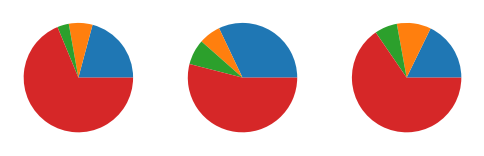

In [65]:
fig = plt.figure(figsize=(6, 2), dpi=100)

# Lists to store group indices with high-strain overlap
valid_groups = [[], [], []]
str_both_g = [[], [], []]     # f-sites where both f-site and p-site show high overlap
str_fsite_g = [[], [], []]    # f-sites with high overlap, regardless of p-site

# Iterate through each comparison label (e.g., L1, L2, L3)
for k, label in enumerate(comparison_label):
    ax = fig.add_subplot(1, 3, k + 1)
    print("\n" + label)

    # Temporary storage for normalized scores and colors
    psite_fc = []
    fsite_fc = []
    color_fc = []

    # Loop through all annotated phosphorylation sites
    for i, psite in enumerate(psites):
        res = int(psite.split("_")[1])
        protein = psite.split("_")[0]

        if protein in annot_uni:
            data_prot = annot[annot["uniprot_id"] == protein]
            groups = list(set(data_prot["site_idx"]))
                    
            # Compute z-score for p-site
            x = (overlap_psite[i, k] - np.nanmean(overlap_psite_bts[i, k])) / np.nanstd(overlap_psite_bts[i, k])
            # Compute z-scores for all f-sites
            y = (overlap_fsite[groups, k] - np.nanmean(overlap_fsite_bts[groups, k], axis=1)) / np.nanstd(overlap_fsite_bts[groups, k], axis=1)

            # Repeat p-site z-score for each associated f-site
            psite_fc += [x] * len(groups)
            fsite_fc += list(y)

            # Thresholding: define enrichment as z-score > 3
            xt = x > 3
            yt = y > 3

            # Color assignment for pie chart
            for g in range(len(groups)):
                if xt == 1 and yt[g] == 0:
                    color_fc += ["C0"]  # Only p-site enriched
                elif xt == 0 and yt[g] == 1:
                    color_fc += ["C1"]  # Only f-site enriched
                    str_fsite_g[k].append(groups[g])
                elif xt == 1 and yt[g] == 1:
                    color_fc += ["C2"]  # Both enriched
                    str_both_g[k].append(groups[g])
                    str_fsite_g[k].append(groups[g])
                    # Print the annotation label and site for logging
                    print(data_prot[data_prot["site_idx"] == groups[g]].iloc[0, 5], psite)
                else:
                    color_fc += ["C3"]  # Neither enriched

                # Store only valid pairs (non-NaN) for later analysis
                if not np.isnan(y[g]) and not np.isnan(x):
                    valid_groups[k].append(groups[g])

    # Keep only non-NaN entries for plotting
    idx = np.sum(np.isnan(list(zip(psite_fc, fsite_fc))), axis=1) == 0
    print(sum(idx))

    # Count instances of each enrichment type for pie chart
    pie_sizes = [np.sum([t == "C" + str(j) for t in np.array(color_fc)[idx]]) for j in range(4)]
    print(pie_sizes)
    ax.pie(pie_sizes)

# Save final figure as SVG
plt.savefig("pie_chart_overlap.svg")

## Enrichment test 

Use a hypergeometric test for enrichment of types of functional sites that are both present in the high deformation manifold

In [72]:
# Initialize containers for results per comparison (PP, PN, NN)
valid_fsite = [[], [], []]   # All valid functional sites with non-NaN values
str_fsite = [[], [], []]     # Functional sites with significant λ₃ deformation only
str_both = [[], [], []]      # Functional sites with significant deformation both at psite and fsite

# Loop over the three comparison groups
for j in range(3):
    # For all valid functional site groups in this comparison
    for g in valid_groups[j]:
        # Extract annotation info (assumed residue number) for each group
        residue_index = annot.loc[annot["site_idx"] == g, annot.columns[5]].iloc[0]
        valid_fsite[j].append(residue_index)

    # For functionally stretched sites only
    for g in str_fsite_g[j]:
        residue_index = annot.loc[annot["site_idx"] == g, annot.columns[5]].iloc[0]
        str_fsite[j].append(residue_index)

    # For sites stretched both as phosphosite and functional site
    for g in str_both_g[j]:
        residue_index = annot.loc[annot["site_idx"] == g, annot.columns[5]].iloc[0]
        str_both[j].append(residue_index)

In [73]:
# Prepare the trimmed datasets for hypergeometric test
dataset_hg = trim_uniprot(valid_fsite[1])  # Prepare dataset of valid functional sites
sampled_hg = trim_uniprot(str_both[1])     # Prepare dataset of sites that are both phosphosite and functional site

M = len(dataset_hg)  # Total number of entries in the dataset (M)
N = len(sampled_hg)  # Total number of entries in the sampled group (N)
nrep = len(np.unique(dataset_hg))  # Number of unique elements in the dataset

# Loop through each unique element in the dataset
for uniq in np.unique(dataset_hg):
    n = dataset_hg.count(uniq)  # Number of occurrences of `uniq` in the dataset
    k = sampled_hg.count(uniq)  # Number of occurrences of `uniq` in the sampled group
    
    # Calculate the p-value of the hypergeometric test (survival function)
    pval = hypergeom.sf(k, M=M, n=n, N=N) < .05 / nrep  # Adjusted p-value with multiple comparisons correction
    
    if pval:
        # Print the unique element, its p-value, and the counts of occurrences in both datasets
        print(uniq, pval, dataset_hg.count(uniq), sampled_hg.count(uniq))
        # Print the raw p-value for hypergeometric test
        print(hypergeom.sf(k, M=M, n=n, N=N))

Binding site::ATP: True 102 26
6.209924632973097e-12
Binding site::NADP(+): True 2 2
0.0


## Shortest distance between P-site and F-site (identified with manifold analyses)


PP
B1L3C9:Binding site::CoA 	psite: 254 	shortest dist: 30.9
B1L3C9:Binding site::acetyl-CoA 	psite: 254 	shortest dist: 30.9
P00489:Binding site::AMP 	psite: 15 	shortest dist: 31.6
P00517:Binding site::ATP 	psite: 11 	shortest dist: 27.9
P05132:Binding site::ATP 	psite: 11 	shortest dist: 28.3
P06737:Binding site::AMP 	psite: 15 	shortest dist: 24.7
P07949:Site:Cleavage: 	psite: 905 	shortest dist: 23.7
P07949:Site:Breakpoint for translocation to form PCM1-RET: 	psite: 905 	shortest dist: 26.8
P12928:Binding site::substrate 	psite: 144 	shortest dist: 48.1
P12931:Binding site::ATP 	psite: 419 	shortest dist: 18.4
P17612:Binding site::ATP 	psite: 11 	shortest dist: 28.1
P28482:Binding site::ATP 	psite: 185 	shortest dist: 22.7
P31751:Binding site::ATP 	psite: 451 	shortest dist: 10.6
P48730:Binding site::ATP 	psite: 220 	shortest dist: 21.6
Q13153:Binding site::ATP 	psite: 423 	shortest dist: 19.8
Q13523:Binding site::ATP 	psite: 849 	shortest dist: 17.5
Q16539:Binding site::ATP 	psi

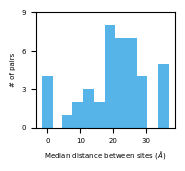

In [80]:
fig = plt.figure(figsize=(1.8, 1.5), dpi=100)

# Loop over each comparison type
for k, label in enumerate(comparison_label):
    print("\n" + label)

    # Initialize storage for z-scores and distance lists
    psite_fc = []
    fsite_fc = []

    co_strained_sp = [] 
    not_co_strained_sp = []

    # Loop through all annotated phosphorylation sites
    for i, psite in enumerate(psites):
        res = int(psite.split("_")[1])         # residue number
        protein = psite.split("_")[0]          # protein ID

        if protein in annot_uni:
            data_prot = annot[annot["uniprot_id"] == protein]
            groups = list(set(data_prot["site_idx"]))

            # Compute z-scores for enrichment
            x = (overlap_psite[i, k] - np.nanmean(overlap_psite_bts[i, k])) / np.nanstd(overlap_psite_bts[i, k])
            y = (overlap_fsite[groups, k] - np.nanmean(overlap_fsite_bts[groups, k], axis=1)) / np.nanstd(overlap_fsite_bts[groups, k], axis=1)

            psite_fc += [x] * len(groups)
            fsite_fc += list(y)

            # Identify sites passing enrichment threshold (Z > 3)
            xt = x > 3
            yt = y > 3

            for g in range(len(groups)):
                if xt and yt[g]:  # Both enriched
                    fres = list(data_prot[data_prot["site_idx"] == groups[g]]["residue"])
                    sp = shortest_dist_pfsite(res, fres, psite)  # Compute min dist
                    
                    # Report co-strained site and its distance
                    print(data_prot[data_prot["site_idx"] == groups[g]].iloc[0, 5], "\tpsite:",
                          res, "\tshortest dist:", np.round(sp[0], 1))
                    
                    co_strained_sp.append(sp[0])
                else:
                    fres = list(data_prot[data_prot["site_idx"] == groups[g]]["residue"])

    # Plot histogram only for P x N
    if k == 1:
        ax = fig.add_subplot(1, 1, 1)

        co_strained_sp = np.array(co_strained_sp)

        # Plot histogram of non-zero distances
        hist = plt.hist(co_strained_sp[co_strained_sp != 0], color="#56b4e9")
        bin_size = hist[1][1] - hist[1][0]

        # Overlay bar for zero distances (exactly co-localized)
        plt.hist(co_strained_sp[co_strained_sp == 0], bins=[-bin_size/2, bin_size/2], color="#56b4e9")

        # Axis labels and ticks
        plt.xlabel("Median distance between sites ($\\AA$)", fontsize=5)
        plt.xticks([0, 10, 20, 30], fontsize=5)
        plt.ylabel("# of pairs", fontsize=5)
        plt.yticks([0, 3, 6, 9], fontsize=5)

    # Summary stats and data completeness
    print(np.mean(co_strained_sp[co_strained_sp != 0]))

    idx = np.sum(np.isnan(list(zip(psite_fc, fsite_fc))), axis=1) == 0
    print(sum(idx))

plt.show()